# Experimental Design
- check word vector's hidden unit's information by using method of paper name "Intriguing properties of neural networks"
- use SVD
- use VAE

In [170]:
from tqdm import tqdm_notebook

import numpy as np
np.random.seed(1)
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

try : 
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    vader = SentimentIntensityAnalyzer()
except : 
    import nltk
    nltk.download('vader_lexicon')  
    vader = SentimentIntensityAnalyzer()
    
import warnings
warnings.simplefilter("ignore")

In [2]:
model = api.load("glove-twitter-200")

In [4]:
lemma_dict = model.key_to_index
vectors = model.vectors

<AxesSubplot:title={'center':'l2-norm'}>

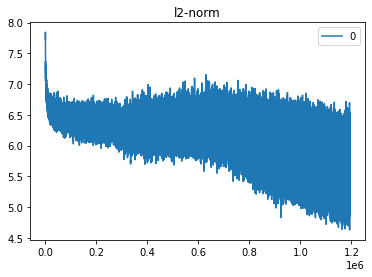

In [155]:
norm_dist = np.linalg.norm(vectors, axis=1)
pd.DataFrame(norm_dist).rolling(100).mean().plot(title='l2-norm')

In [157]:
vectors = normalize(vectors, axis=1)

___

its pretrained vector space can be said orthogonal

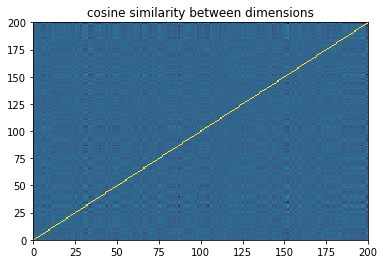

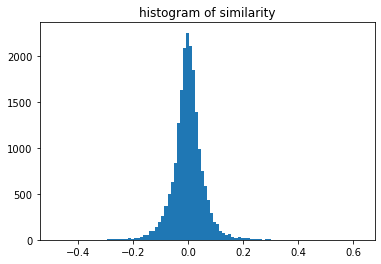

In [158]:
cossim_mat = cosine_similarity(vectors.transpose(1,0))
plt.title("cosine similarity between dimensions")
plt.pcolor(cossim_mat)
plt.show()

cossim_mat[np.tril_indices_from(cossim_mat)] = np.nan
plt.title("histogram of similarity")
_ = plt.hist(cossim_mat[np.isfinite(cossim_mat)], bins=100)
plt.show()

____

In [159]:
def get_word_candidates(init, sim_const) :
    cand = []
    for w in model.similar_by_word(init) : 
        if w[1] > sim_const : 
            cand.append(w[0])
    return cand

iteratively search sentiment vocab

In [200]:
pos_container = []
cand = get_word_candidates('great', sim_const=0.75) # positiv word init
pos_container += cand
iters = 3

for proc in range(iters) :
    cand = list(set(pos_container))
    for query in cand : 
        value = get_word_candidates(query, sim_const=0.75)
        pos_container += value

neg_container = []
cand = get_word_candidates('bad', sim_const=0.75) # negative word init
neg_container += cand
iters = 3

for proc in range(iters) :
    cand = list(set(neg_container))
    for query in cand : 
        value = get_word_candidates(query, sim_const=0.75)
        neg_container += value
        
sentiment_vocab = list(set(pos_container).union(set(neg_container)))
print("===" * 10)
print("The # of positive words picked :", len(set(pos_container)))
print("The # of negative words picked :", len(set(neg_container)))
print("The # of sentimental words picked :", len(sentiment_vocab))
print("The # of intersection between pos/neg :", len(set(pos_container).intersection(set(neg_container))))
print("===" * 10)

The # of positive words picked : 282
The # of negative words picked : 384
The # of sentimental words picked : 441
The # of intersection between pos/neg : 225


In [112]:
sentiment_idx = [v for k,v in lemma_dict.items() if k in sentiment_vocab]
notsentiment_idx = [v for k,v in lemma_dict.items() if k not in sentiment_vocab]
positive_idx = [v for k,v in lemma_dict.items() if k in set(pos_container)]
negative_idx = [v for k,v in lemma_dict.items() if k in set(neg_container)]

# to easy-compare and visualize, I sampled the same number for indexes from ~sentiment candidates
# since it gives stochasticity in research, we need to do sampling multiple times for more robust result 
notsentiment_idx = np.random.choice(notsentiment_idx, len(sentiment_idx), replace=False)

In [161]:
notsentiment_vector = vectors[notsentiment_idx]
sentiment_vector = vectors[sentiment_idx]

____

In [114]:
def calc_ztest(dist1, dist2) : 
    mean1 = np.mean(dist1)
    mean2 = np.mean(dist2)
    std1 = np.std(dist1)
    std2 = np.std(dist2)
    return (mean1-mean2)/np.sqrt(std1**2+std2**2)

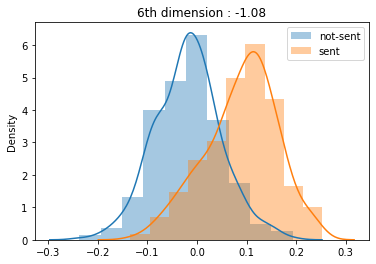

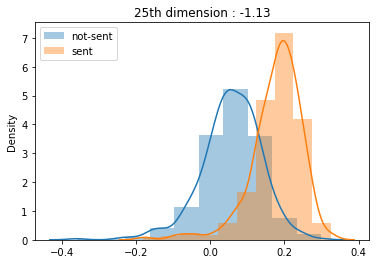

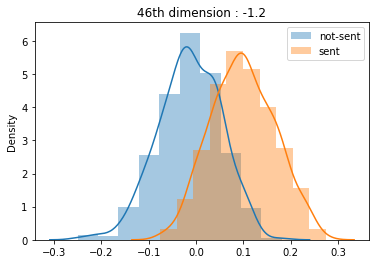

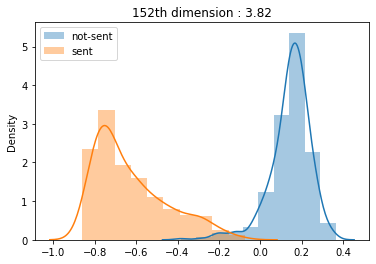

In [162]:
embed_dim = vectors.shape[1]
score_mem = []

for idx in range(embed_dim) : 
    score = np.round(calc_ztest(notsentiment_vector[:,idx], sentiment_vector[:,idx]), 2)    
    if np.abs(score) >= 1 : 
        score_mem.append(idx)
        plt.title("{}th dimension : {}".format(idx, score))    
        _ = sns.distplot(notsentiment_vector[:,idx], bins=10, label='not-sent')
        _ = sns.distplot(sentiment_vector[:,idx], bins=10, label='sent')
        plt.legend()
        plt.show()

In [196]:
vocab_ls = list(lemma_dict.keys())
word_from_dist1 = [vocab_ls[idx] for idx, b in enumerate((vectors[:,152] < -.6) & (vectors[:,152] > -1)) if b]
sent_from_dist1 = [vader.polarity_scores(w)['compound'] for w in word_from_dist1]
no_sentiment_corpus = [i for i in sent_from_dist1 if i != 0]
ratio = len(no_sentiment_corpus)/len(word_from_dist1)
print("Sentimental word ratio : {}".format(np.round(ratio, 4)))

Sentimental word ratio : 0.1964


In [197]:
vocab_ls = list(lemma_dict.keys())
word_from_dist2 = [vocab_ls[idx] for idx, b in enumerate((vectors[:,152] < .4) & (vectors[:,152] > 0)) if b]
sent_from_dist2 = [vader.polarity_scores(w)['compound'] for w in word_from_dist2]
no_sentiment_corpus = [i for i in sent_from_dist2 if i != 0]
ratio = len(no_sentiment_corpus)/len(word_from_dist2)
print("Sentimental word ratio : {}".format(np.round(ratio, 4)))

Sentimental word ratio : 0.0014


____

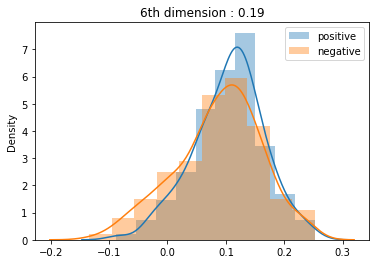

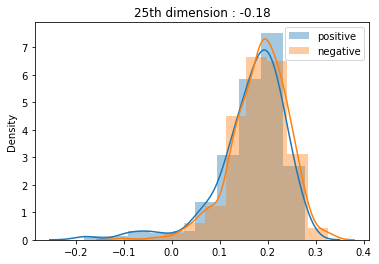

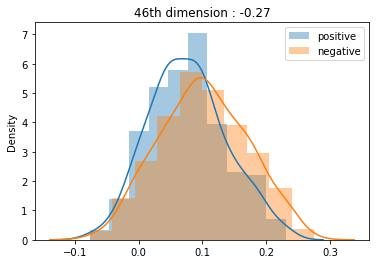

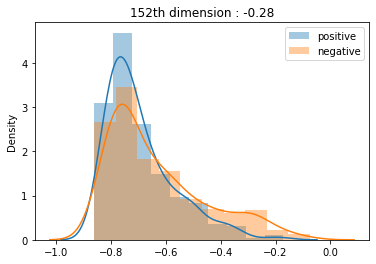

In [163]:
for idx in score_mem : 
    dist1 = vectors[positive_idx][:,idx]
    dist2 = vectors[negative_idx][:,idx]
    score = np.round(calc_ztest(dist1, dist2), 2)    
    
    plt.title("{}th dimension : {}".format(idx, score))
    _ = sns.distplot(dist1, bins=10, label='positive')
    _ = sns.distplot(dist2, bins=10, label='negative')
    plt.legend()
    plt.show()